In [1]:
import time

from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
sns.set_style(style='dark')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Устройство: {device}')
print(f'Версия pytorch: {torch.__version__}')

Устройство: cuda
Версия pytorch: 2.3.0.dev20240105+cu121


In [2]:
def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
    scheduler=None

):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        if scheduler != None:
            scheduler.step()

        plot_learning_curves(history)
        
    return model, history

In [7]:
batch_size = 256

train_dataset = torchvision.datasets.FashionMNIST('./dataset/', train=True, transform=torchvision.transforms.ToTensor(), download=False)
test_dataset = torchvision.datasets.FashionMNIST('./dataset/', train=False, transform=torchvision.transforms.ToTensor(), download=False)
train_batch = torch.utils.data.DataLoader(train_dataset, batch_size)
test_batch = torch.utils.data.DataLoader(test_dataset, batch_size)

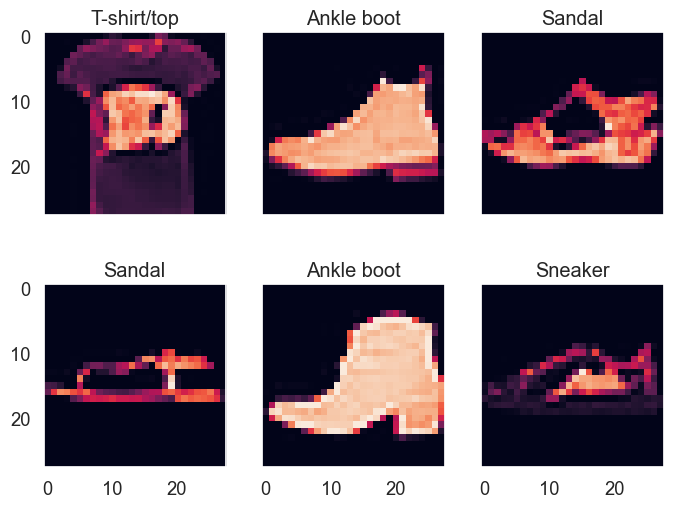

In [8]:
show_images(train_dataset)

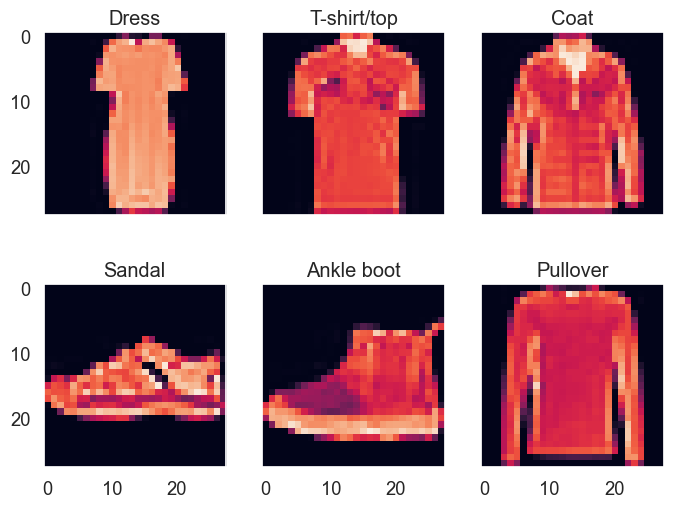

In [9]:
show_images(test_dataset)

Epoch 20 of 20 took 45.997s
  training loss (in-iteration): 	0.169665
  validation loss (in-iteration): 	0.271825
  training accuracy: 			93.54 %
  validation accuracy: 			90.85 %


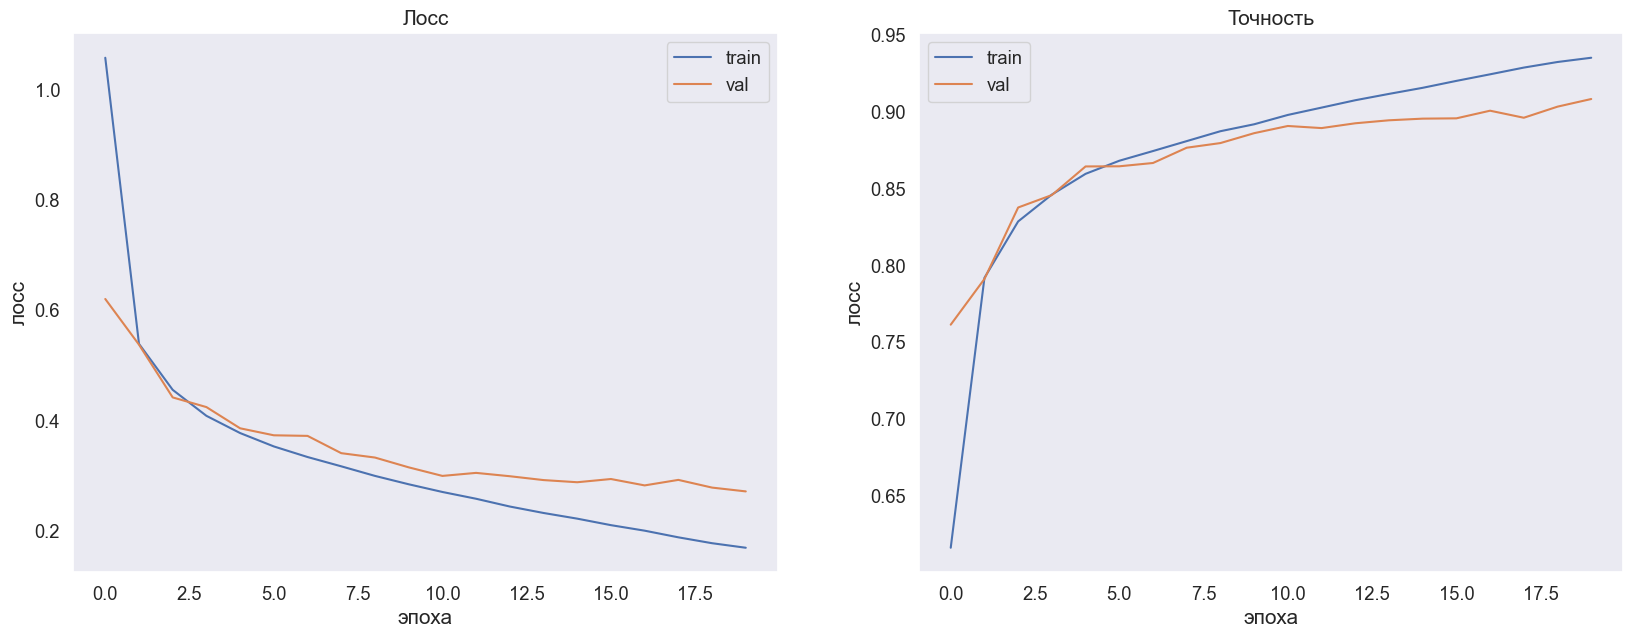

In [13]:
model = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=16, kernel_size=2, stride=1, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(13456, 2560),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(2560, 1280),
    nn.Linear(1280, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

clf_model, history = train(
    model, criterion, optimizer, 
    train_batch, test_batch, 
    num_epochs=20
)

# Получение состояния модели
model_state = model.state_dict()

# Путь к файлу для сохранения весов
weights_path = "weights"

# Сохранение весов в файл
torch.save(model_state, weights_path)